In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('startup_funding_clean.csv')

In [3]:
# Create a copy of the data
model_df = df.copy()

In [4]:
# Create a new column counting the number of investors per startup
model_df['No Of Investors'] = (
    model_df['Investors Name']
    .astype(str)
    .apply(lambda x: len([i for i in x.split(',') if i.strip() != '']))  # ignore empty entries
)

In [5]:
# Target variable: 1 = Successful (> ₹10 Cr), 0 = Not Successful
model_df['Success'] = (model_df['Amount in INR(K)'] > 1_00_000).astype(int)

In [6]:
# Select features
features = ['City Location', 'Industry Vertical', 'Investment Type', 'No Of Investors']
target = 'Success'

In [7]:
# Encode categorical features
le = LabelEncoder()
for col in ['City Location', 'Industry Vertical', 'Investment Type']:
    model_df[col] = le.fit_transform(model_df[col].astype(str))

In [8]:
# Fill missing numerical values
model_df['No Of Investors'] = model_df['No Of Investors'].fillna(model_df['No Of Investors'].median())

In [9]:
# Train-test split
X = model_df[features]
y = model_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# -------------------------------
# Logistic Regression (with class balance)
# -------------------------------
log_model = LogisticRegression(max_iter=500, class_weight='balanced')
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("*** Logistic Regression Results ***")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("F1 Score:", f1_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

*** Logistic Regression Results ***
Accuracy: 0.84375
F1 Score: 0.860813704496788

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82       187
           1       0.84      0.88      0.86       229

    accuracy                           0.84       416
   macro avg       0.84      0.84      0.84       416
weighted avg       0.84      0.84      0.84       416



In [12]:
# -------------------------------
# Random Forest (with class balance)
# -------------------------------
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n *** Random Forest Results ***")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))



 *** Random Forest Results ***
Accuracy: 0.8389423076923077
F1 Score: 0.8607068607068608

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.76      0.81       187
           1       0.82      0.90      0.86       229

    accuracy                           0.84       416
   macro avg       0.84      0.83      0.83       416
weighted avg       0.84      0.84      0.84       416



In [13]:
# -------------------------------
# Metrics & Comparison
# -------------------------------
models = ['Logistic Regression', 'Random Forest']
accuracy = [accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred_rf)]
f1 = [f1_score(y_test, y_pred_log), f1_score(y_test, y_pred_rf)]

comparison_df = pd.DataFrame({'Model': models, 'Accuracy': accuracy, 'F1 Score': f1})
print(comparison_df)

                 Model  Accuracy  F1 Score
0  Logistic Regression  0.843750  0.860814
1        Random Forest  0.838942  0.860707


In [14]:
# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Confusion Matrix:
[[142  45]
 [ 22 207]]


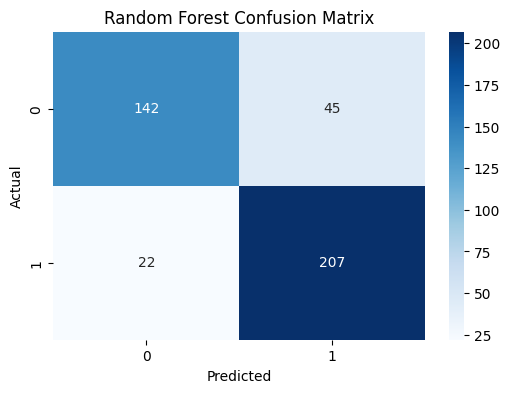

In [15]:
# Confusion Matrix for Random Forest
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

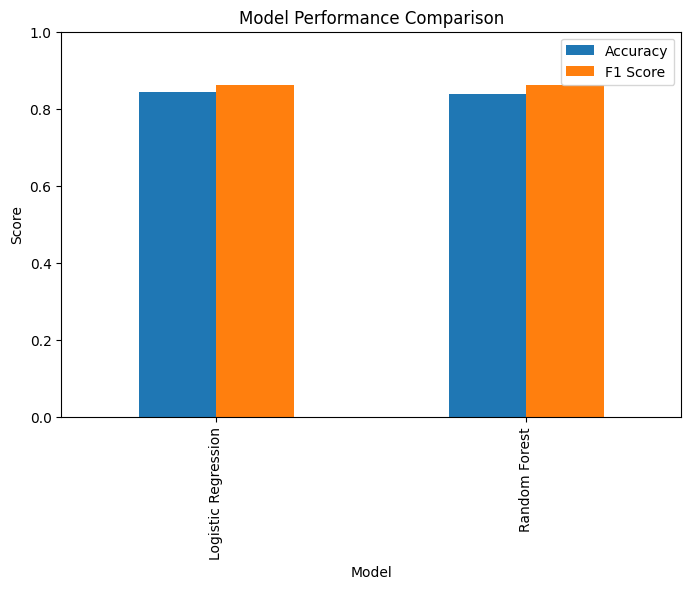

In [16]:
# Visual Comparison
comparison_df.set_index('Model').plot(kind='bar', figsize=(8,5))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()

/tmp/ipython-input-3460597196.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


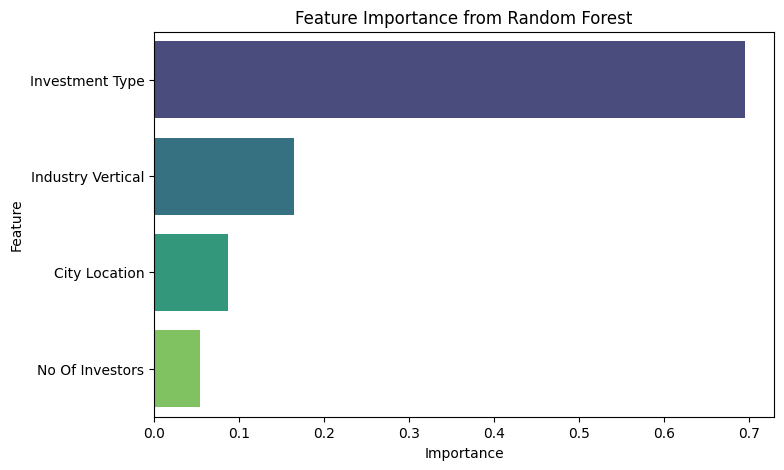

In [17]:
# Get feature importances from Random Forest
feature_importances = rf_model.feature_importances_
features = X.columns

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

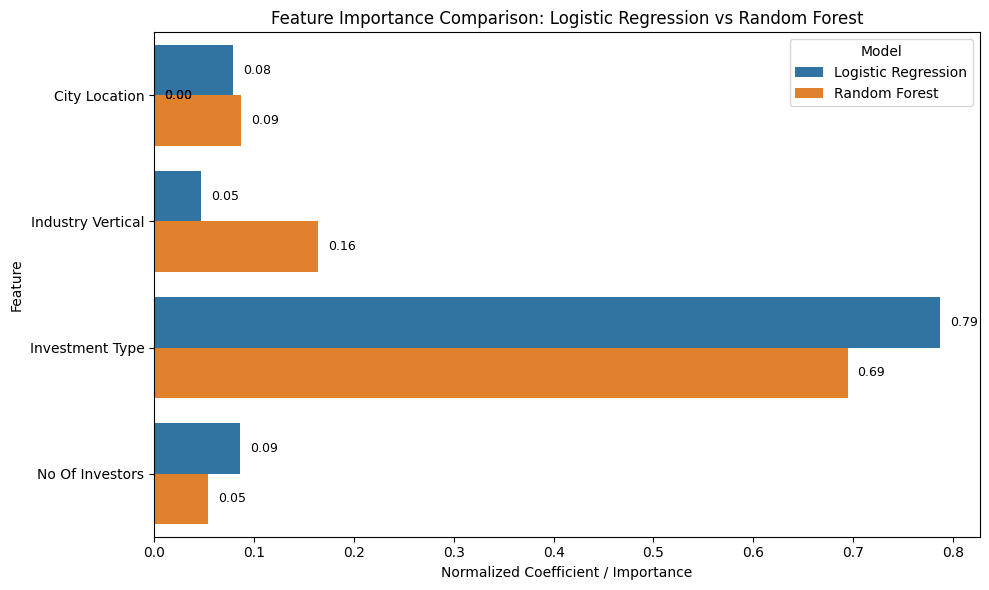

In [18]:
# Get logistic regression coefficients
log_coef = np.abs(log_model.coef_[0])
log_coef_norm = log_coef / log_coef.sum()

# Get random forest feature importances
rf_importances = rf_model.feature_importances_
rf_importances_norm = rf_importances / rf_importances.sum()

# Create DataFrame
comparison_df = pd.DataFrame({
    'Feature': features,
    'Logistic Regression': log_coef_norm,
    'Random Forest': rf_importances_norm
})

# Melt to long format for seaborn
comparison_df_melted = comparison_df.melt(id_vars='Feature',
                                          var_name='Model',
                                          value_name='Normalized Importance')

# Plot
plt.figure(figsize=(10,6))
bar_plot = sns.barplot(x='Normalized Importance', y='Feature', hue='Model', data=comparison_df_melted)

# Add numeric values on bars
for p in bar_plot.patches:
    width = p.get_width()
    bar_plot.text(width + 0.01,
                  p.get_y() + p.get_height()/2,
                  f'{width:.2f}',
                  ha='left', va='center', fontsize=9)

plt.title("Feature Importance Comparison: Logistic Regression vs Random Forest")
plt.xlabel("Normalized Coefficient / Importance")
plt.ylabel("Feature")
plt.legend(title='Model')
plt.tight_layout()
plt.show()


In [19]:
# Save preprocessed data to CSV
model_df.to_csv('preprocessed_startups.csv', index=False)

In [20]:
import joblib

# Save Logistic Regression model
joblib.dump(log_model, 'logistic_model.pkl')

# Save Random Forest model
joblib.dump(rf_model, 'random_forest_model.pkl')

# Save the scaler (important for new predictions)
joblib.dump(scaler, 'scaler.pkl')

# Save LabelEncoders for categorical columns
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']